In [22]:
'''
Pickle is a built-in Python module used for serializing and deserializing Python objects.
pickle can be used to save trained models to disk. Enabling to save your trained model and load it later without having to retrain it every time you want to use it.
'''

import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [23]:
data = pd.read_csv('./data/churn.csv')
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## EDA

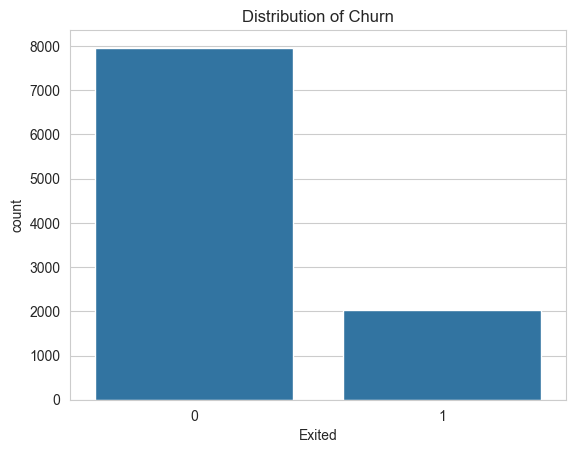

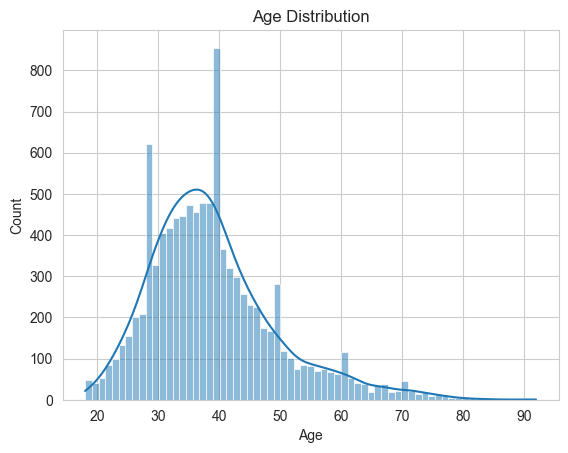

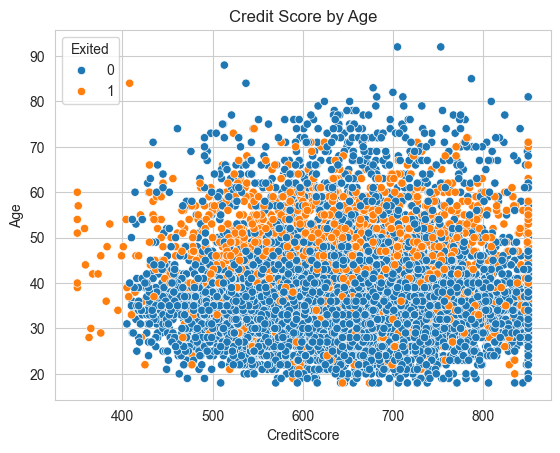

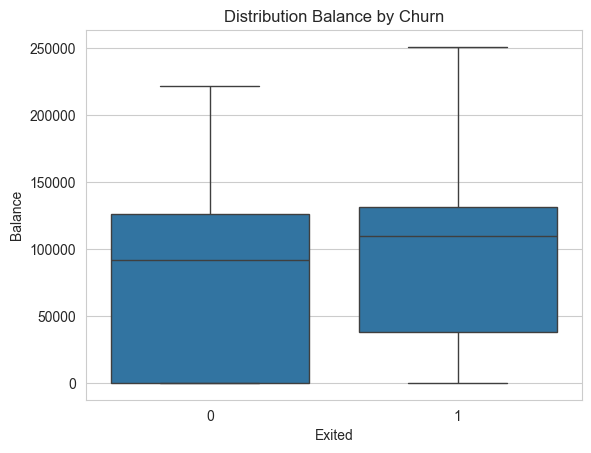

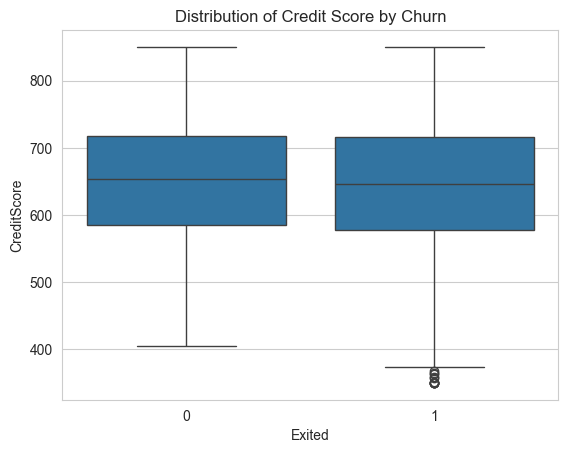

In [24]:
# Setup environment
sns.set_style(style="whitegrid")

# Distribution of churns (exited)
sns.countplot(data=data, x="Exited")
plt.title("Distribution of Churn")
plt.show()

# Histogram of custoemr ages
sns.histplot(data=data, x="Age", kde=True)
plt.title("Age Distribution")
plt.show()

# Credit Score by Age
sns.scatterplot(data=data, y="Age", x="CreditScore", hue="Exited")
plt.title("Credit Score by Age")
plt.show()

# Distribution Balance by churn
sns.boxplot(data=data, x="Exited", y="Balance")
plt.title("Distribution Balance by Churn")
plt.show()

# Distribution of credit score by churn
sns.boxplot(data=data, x="Exited", y="CreditScore")
plt.title("Distribution of Credit Score by Churn")
plt.show()


## Data Preparation

**Auxiliar Functions**

In [25]:
def save_object(object, filename, directory):
  try:
    with open(os.path.join(directory, filename), 'wb') as file:
      pickle.dump(object, file)
  except Exception as e:
    print(f"Error saving object: {e}")
  return None

**Select features and handle NA**

In [26]:
# separate features and target
features = data.drop('Exited', axis=1)
target = data['Exited']

## feature selection
# remove unnecessary columns
features = features.drop(["RowNumber", "CustomerId", "Surname"], axis=1)
# handle missing values
print('Shape before dropna:', features.shape)
features.dropna(inplace=True)
print('Shape after dropna:', features.shape)

# handle categorical features: one-hot encoding
features = pd.get_dummies(data=features, columns=["Geography", "Gender"])

Shape before dropna: (10000, 10)
Shape after dropna: (10000, 10)


In [27]:
# SPLIT
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [28]:
# SCALE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# save scaler
save_object(scaler, 'scaler.pkl', 'models')

## Model Training

**EXAMPLE**

In [29]:
# TRAIN
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [30]:
# PREDICT
lr_predictions = lr_model.predict(X_test)

In [31]:
# EVALUATE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print('Accuracy Score:', accuracy_score(y_test, lr_predictions))
print('Confusion Matrix:')
confusion_matrix(y_true=y_test, y_pred=lr_predictions)

Accuracy Score: 0.811
Confusion Matrix:


array([[1541,   66],
       [ 312,   81]])

**COMPARE MODELS**

In [32]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [33]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test, filename='model.pkl', directory=None):
  # fit
  model.fit(X_train, y_train)
  # predict
  y_pred = model.predict(X_test)
  # get accuracy
  accuracy = accuracy_score(y_test,y_pred)
  # report accuracy
  print(f'{model.__class__.__name__} Accuracy: {accuracy:.4f}')
  # create classification report
  print(classification_report(y_test, y_pred))

  # save model to file if directory provided
  if directory:
    save_object(model, filename, directory)

  # pretty layout
  print('*' * 50)

  return None

In [34]:
lrg_model = LogisticRegression(random_state=42)
train_and_evaluate(lrg_model, X_train, X_test, y_train, y_test, 'lgr_model.pkl', './models')

xgb_model = xgb.XGBClassifier(random_state=42)
train_and_evaluate(xgb_model, X_train, X_test, y_train, y_test, 'xgb_model.pkl', './models')

rfc_model = RandomForestClassifier(random_state=42)
train_and_evaluate(rfc_model, X_train, X_test, y_train, y_test, 'rfc_model.pkl', './models')

tre_model = DecisionTreeClassifier(random_state=42)
train_and_evaluate(tre_model, X_train, X_test, y_train, y_test, 'tre_model.pkl', './models')

gnb_model = GaussianNB()
train_and_evaluate(gnb_model, X_train, X_test, y_train, y_test, 'gnb_model.pkl', './models')

knn_model = KNeighborsClassifier()
train_and_evaluate(knn_model, X_train, X_test, y_train, y_test, 'knn_model.pkl', './models')

svm_model = SVC(random_state=42)
train_and_evaluate(svm_model, X_train, X_test, y_train, y_test, 'svm_model.pkl', './models')

LogisticRegression Accuracy: 0.8110
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1607
           1       0.55      0.21      0.30       393

    accuracy                           0.81      2000
   macro avg       0.69      0.58      0.60      2000
weighted avg       0.78      0.81      0.77      2000

**************************************************
XGBClassifier Accuracy: 0.7455
              precision    recall  f1-score   support

           0       0.88      0.80      0.83      1607
           1       0.39      0.54      0.45       393

    accuracy                           0.75      2000
   macro avg       0.63      0.67      0.64      2000
weighted avg       0.78      0.75      0.76      2000

**************************************************
RandomForestClassifier Accuracy: 0.8645
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75     

Observation: XGBoost does not have the highest accuracy, but it has the highest recall of the churners.

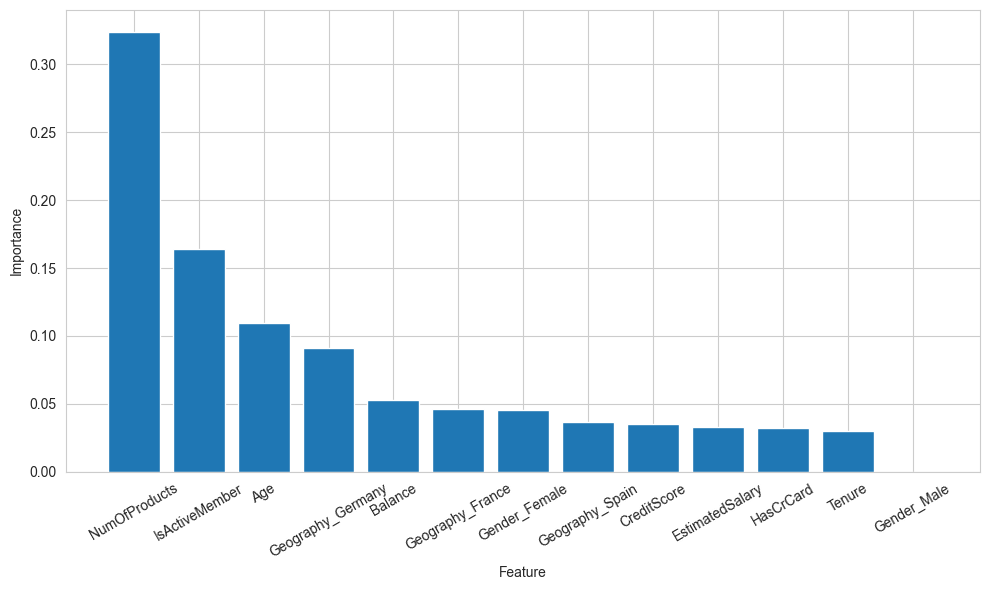

In [35]:
# get feature importance
feature_importances = xgb_model.feature_importances_
feature_names = features.columns

feature_importances_df = pd.DataFrame(zip(feature_names, feature_importances))
feature_importances_df.columns = ['feature', 'importance']

feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# plot bar chart
plt.figure(figsize=(10,6))
plt.bar(feature_importances_df['feature'], feature_importances_df['importance'])

# configure chart
plt.xticks(rotation=30)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

## Improve Model Accuracy

### Feature Engineering

In [36]:
## CREATE FEATURES
# CLV = balance * salary / 100000
features['CLV'] = features['Balance'] * features['EstimatedSalary'] / 100000
# tenure / age
features['TenureByAge'] = features['Tenure'] / features['Age']
# age group -> create bins 0,30,45,60,100
if('AgeGroup_Adult' not in features.columns):
  features['AgeGroup'] = pd.cut(features['Age'], [0, 30, 45, 60, 100], labels=['Young', 'Adult', 'Senior', 'Elderly'])
  features = pd.get_dummies(features, ['AgeGroup'], drop_first=True)

In [37]:
# SPLIT
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# SCALE
scaler_feate = StandardScaler()
X_train = scaler_feate.fit_transform(X_train)
X_test = scaler_feate.fit_transform(X_test)

save_object(scaler_feate, 'scaler_feate.pkl', 'models')

In [38]:
features.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male',
       'CLV', 'TenureByAge', 'AgeGroup_Adult', 'AgeGroup_Senior',
       'AgeGroup_Elderly'],
      dtype='object')

**Use engineered features with XGB model**

In [ ]:
# CREATE MODEL
xgb_model_feate = xgb.XGBClassifier(random_state=42)

# EVALUATE
train_and_evaluate(xgb_model_feate, X_train, X_test, y_train, y_test, 'xgb_model_feate.pkl', './models')

### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_resampled, y_resampled, = smote.fit_resample(X_train, y_train)

train_and_evaluate(xgb_model_feate, X_resampled, X_test, y_resampled, y_test, 'xgb_smote.pkl', './models')

### Ensemble + SMOTE

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
  estimators=[('xgb',xgb.XGBClassifier(random_state=42)),
              ('rfc',RandomForestClassifier(random_state=42)),
              ('svm',SVC(random_state=42, probability=True))],
  voting='soft' # weight predictions by accuracy 
)

train_and_evaluate(voting_clf, X_resampled, X_test, y_resampled, y_test, 'xgb_ensemble_soft.pkl', './models')

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf_hard = VotingClassifier(
  estimators=[('xgb',xgb.XGBClassifier(random_state=42)),
              ('rfc',RandomForestClassifier(random_state=42)),
              ('svm',SVC(random_state=42, probability=True))],
  voting='hard' # simple majority vote of models
)

train_and_evaluate(voting_clf_hard, X_resampled, X_test, y_resampled, y_test, 'xgb_ensemble_hard.pkl', './models')